First, 300 candidate datasets were created by randomly selecting between 4-13 classes, assigning majority classes with a "Very High" sample size, and ensuring no more than half the classes are majority. Specific constraints for classes 4, 6, and 7 were applied to limit their maximum sample sizes.

In [ ]:
import pandas as pd
import os
import random

# Constants
num_candidates = 2  # Number of candidate datasets
num_classes_total = 13
class_counts = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
sample_sizes = {'Very Low': 500, 'Low': 1000, 'Intermediate': 2500, 'High': 5000, 'Very High': 10000}
majority_class_tracker = {c: 0 for c in range(num_classes_total)}

output_folder = '/data/private/BreizhCrops/experiments/undersampled_csvs/dataset_generation/candidate_datasets_42'
seed = 42
random.seed(seed)

# Constraints for specific classes
max_sample_size = {4: 'High', 6: 'Low', 7: 'Intermediate'}

def undersample_csvs(classes_to_undersample, name, seed, output_folder, regions=['frh01', 'frh02', 'frh03']):
    root_path = '/data/private/BreizhCrops/data/2017/L1C/'
    
    modified_folder = os.path.join(output_folder, name)
    os.makedirs(modified_folder, exist_ok=True)

    class_distribution_info = []
    total_distribution_original = pd.Series(dtype=int)
    total_distribution_undersampled = pd.Series(dtype=int)
    original_distribution_per_region = {}
    classes_eliminated = []

    for region in regions:
        csv_file_path = os.path.join(root_path, f'{region}.csv')
        df = pd.read_csv(csv_file_path)
        original_distribution = df['classid'].value_counts()
        original_distribution_per_region[region] = original_distribution
        total_distribution_original = total_distribution_original.add(original_distribution, fill_value=0)

    for region in regions:
        csv_file_path = os.path.join(root_path, f'{region}.csv')
        df = pd.read_csv(csv_file_path)

        df_undersampled = pd.DataFrame(columns=df.columns)
        for class_id, total_desired_samples in classes_to_undersample.items():
            if total_desired_samples == 0:
                classes_eliminated.append(class_id)
            class_proportion = df[df['classid'] == class_id].shape[0] / total_distribution_original[class_id]
            region_desired_samples = round(class_proportion * total_desired_samples)
            df_class = df[df['classid'] == class_id]
            df_class_undersampled = df_class.sample(n=min(region_desired_samples, len(df_class)), random_state=seed)
            df_undersampled = pd.concat([df_undersampled, df_class_undersampled], ignore_index=True)

        # Set all other classes to 0
        for class_id in df['classid'].unique():
            if class_id not in classes_to_undersample:
                classes_to_undersample[class_id] = 0

        df_undersampled = df_undersampled.sample(frac=1, random_state=seed).reset_index(drop=True)
        new_distribution = df_undersampled['classid'].value_counts()
        total_distribution_undersampled = total_distribution_undersampled.add(new_distribution, fill_value=0)

        undersampled_csv_file_path = os.path.join(modified_folder, f'{region}.csv')
        df_undersampled.to_csv(undersampled_csv_file_path, index=False)

        class_distribution_info.append((region, original_distribution, new_distribution))
        
        # Processing frh04.csv
    frh04_path = '/data/private/BreizhCrops/data/2017/L1C/frh04.csv'    
    df_frh04 = pd.read_csv(frh04_path)
    for class_id in classes_eliminated:
        df_frh04 = df_frh04[df_frh04['classid'] != class_id]
    frh04_csv_file_path = os.path.join(modified_folder, 'frh04.csv')
    df_frh04.to_csv(frh04_csv_file_path, index=False)
    frh04_distribution = df_frh04['classid'].value_counts()

    # Save class distribution info to a text file
    distribution_file_path = os.path.join(modified_folder, 'class_distribution_info.txt')
    with open(distribution_file_path, 'w') as file:
        file.write(f"Seed used for undersampling: {seed}\n\n")
        for region, original, new in class_distribution_info:
            file.write(f"Original distribution for {region}:\n{original.to_string()}\n")
            file.write(f"New distribution after undersampling for {region}:\n{new.to_string()}\n\n")
        file.write("Total original distribution across all regions:\n")
        file.write(total_distribution_original.to_string())
        file.write("\n\nTotal undersampled distribution across all regions:\n")
        file.write(total_distribution_undersampled.to_string())
        file.write("\nClass distribution for frh04 (not undersampled, classes removed if zeroed in training datasets):\n")
        file.write(frh04_distribution.to_string())

    # Prepare CSV data
    class_ids = sorted(set(total_distribution_original.index.union(total_distribution_undersampled.index)))
    csv_data = {'class_id': class_ids}

    for region in regions:
        original_distribution = original_distribution_per_region[region]
        for class_id in class_ids:
            csv_data.setdefault(f'original_{region}', []).append(original_distribution.get(class_id, 0))

        _, _, new_distribution = next((x for x in class_distribution_info if x[0] == region), (None, None, None))
        for class_id in class_ids:
            csv_data.setdefault(f'undersampled_{region}', []).append(new_distribution.get(class_id, 0))

    for class_id in class_ids:
        csv_data.setdefault('original_total', []).append(total_distribution_original.get(class_id, 0))
        csv_data.setdefault('undersampled_total', []).append(total_distribution_undersampled.get(class_id, 0))

    # Save class distribution info to a CSV file
    distribution_csv_file_path = os.path.join(modified_folder, 'class_distribution_info.csv')
    pd.DataFrame(csv_data).to_csv(distribution_csv_file_path, index=False)

# Define functions for candidate dataset generation
def select_num_classes():
    return random.choice(class_counts)

def select_majority_classes(num_classes):
    num_majority_classes = random.randint(1, num_classes // 2)  # Ensure at least one, but not more than half
    majority_classes = random.sample(range(num_classes_total), num_majority_classes)
    for cls in majority_classes:
        majority_class_tracker[cls] += 1
    return majority_classes

def select_remaining_classes(majority_classes, num_classes):
    remaining_classes = list(set(range(num_classes_total)) - set(majority_classes))
    return random.sample(remaining_classes, num_classes - len(majority_classes))

def assign_sample_sizes(remaining_classes, majority_classes):
    samples = {}
    
    # Assign majority classes, ensuring constrained classes are not assigned 'Very High'
    for cls in majority_classes:
        if cls in max_sample_size:
            max_size = max_sample_size[cls]
            size_options = [size for size in sample_sizes.values() if size <= sample_sizes[max_size]]
            samples[cls] = random.choice(size_options)
        else:
            samples[cls] = sample_sizes['Very High']

    # Assign remaining classes
    for c in remaining_classes:
        if c not in samples:  # Ensure we don't overwrite the already assigned majority classes
            if c in max_sample_size:
                max_size = max_sample_size[c]
                size_options = [size for size in sample_sizes.values() if size <= sample_sizes[max_size]]
            else:
                size_options = list(sample_sizes.values())[:-1]
            samples[c] = random.choice(size_options)
    
    return samples

def generate_candidate():
    num_classes = select_num_classes()
    majority_classes = select_majority_classes(num_classes)
    remaining_classes = select_remaining_classes(majority_classes, num_classes)
    class_samples = assign_sample_sizes(remaining_classes, majority_classes)
    return {'classes': majority_classes + remaining_classes, 'samples': class_samples}

# Generate candidate datasets
candidates = []
for i in range(1, num_candidates + 1):
    candidate = generate_candidate()
    dataset_name = str(i)
    undersample_csvs(candidate['samples'], dataset_name, seed, output_folder)
    candidates.append(candidate)

# Create and save a summary CSV of all candidate datasets
candidate_summaries = []

for i, candidate in enumerate(candidates, start=1):
    summary = {'dataset_id': i}
    dataset_folder = os.path.join(output_folder, str(i))
    summary_csv_path = os.path.join(dataset_folder, 'class_distribution_info.csv')
    df_summary = pd.read_csv(summary_csv_path)
    for class_id in range(num_classes_total):
        total_samples = df_summary[df_summary['class_id'] == class_id]['undersampled_total'].values[0] if class_id in df_summary['class_id'].values else 0
        summary[f'class_{class_id}'] = total_samples
    candidate_summaries.append(summary)

candidates_df = pd.DataFrame(candidate_summaries)
candidates_df.to_csv(os.path.join(output_folder, 'candidate_datasets_summary.csv'), index=False)


Then (modifed) N1 is calculated for each canditate dataset, using 200 samples per class due to the computational load of calculating it for all full datasets.
Note, this code can be made more efficient by calculating the N1 on each unique class combination.

In [ ]:
import os
import pandas as pd
import h5py
import numpy as np
from scipy.sparse.csgraph import minimum_spanning_tree
from joblib import Parallel, delayed
import multiprocessing
import csv
import time

# Constants
SEQUENCE_LENGTH = 45
SELECTED_BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9']  # Example for L1C level
BAND_COUNT = 13  


def read_index_files(folder_path, sample_limit_per_class=None):
    index_files = ['frh01', 'frh02', 'frh03']
    samples = []
    labels = []

    for index_file in index_files:
        index_path = os.path.join(folder_path, index_file + '.csv')

        if not os.path.isfile(index_path):
            print(f"File not found: {index_path}")
            continue

        df = pd.read_csv(index_path)
        samples.extend(df['path'].tolist())
        labels.extend(df['classid'].tolist())

    # Create a DataFrame for easier manipulation
    df = pd.DataFrame({'path': samples, 'classid': labels})

    # If sample_limit_per_class is specified, select an equal number of samples from each class
    if sample_limit_per_class is not None:
        df_balanced = df.groupby('classid').apply(lambda x: x.sample(n=sample_limit_per_class, random_state=42, replace=True if len(x) < sample_limit_per_class else False))
        df_balanced = df_balanced.reset_index(drop=True)
        samples = df_balanced['path'].tolist()
        labels = df_balanced['classid'].tolist()

    # Sanity check for number of samples per class
    class_counts = pd.Series(labels).value_counts()
    print("Sample counts per class after sampling:")
    print(class_counts)

    return samples, labels


def transform_and_pad(data, sequence_length=SEQUENCE_LENGTH, band_count=BAND_COUNT):
    # Select the first 'band_count' dimensions and scale reflectances
    data = data[:, :band_count].astype(np.float32) * 1e-4  # Scale reflectances to 0-1

    # Pad or truncate to 'sequence_length'
    if data.shape[0] < sequence_length:
        pad_width = sequence_length - data.shape[0]
        data = np.pad(data, ((0, pad_width), (0, 0)), 'constant', constant_values=0)
    else:
        data = data[:sequence_length]

    return data

def load_time_series_data(samples, base_data_path):
    time_series_data = []

    for sample in samples:
        try:
            sample_path_parts = sample.split('/')
            region, csv_file = sample_path_parts[1], sample_path_parts[-1]
            h5_file_path = os.path.join(base_data_path, '2017', 'L1C', region + '.h5')

            if not os.path.isfile(h5_file_path):
                print(f"H5 file not found: {h5_file_path}")
                continue  # Skip to the next sample if the file is not found

            with h5py.File(h5_file_path, 'r') as f:
                csv_data_path = os.path.join('csv', region, csv_file)
                if csv_data_path not in f:
                    print(f"Dataset not found in H5 file: {csv_data_path}")
                    continue

                data = np.array(f[csv_data_path], dtype=np.float32)
                data = transform_and_pad(data)
                time_series_data.append(data)

        except Exception as e:
            print(f"Error loading sample {sample}: {e}")

    return np.array(time_series_data, dtype=np.float32)

def calculate_euclidean_distance(data1, data2):
    return np.sqrt(np.sum((data1 - data2) ** 2))

def calculate_pairwise_distances(data):
    n_samples = data.shape[0]
    dist_matrix = np.zeros((n_samples, n_samples), dtype=np.float32)

    def compute_distance(i, j):
        return calculate_euclidean_distance(data[i], data[j])

    results = Parallel(n_jobs=multiprocessing.cpu_count())(
        delayed(compute_distance)(i, j) for i in range(n_samples) for j in range(i + 1, n_samples)
    )

    k = 0
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            dist_matrix[i, j] = results[k]
            dist_matrix[j, i] = results[k]
            k += 1

    return dist_matrix

def calculate_fraction_of_borderline_points(time_series_data, labels):
    n_samples = time_series_data.shape[0]

    # Calculate pairwise distances directly between the 2D arrays (samples)
    dist_matrix = calculate_pairwise_distances(time_series_data)
    print("Calculated pairwise distance matrix")

    mst = minimum_spanning_tree(dist_matrix).toarray()
    borderline_edges = 0

    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if mst[i, j] > 0 or mst[j, i] > 0:
                if labels[i] != labels[j]:
                    borderline_edges += 1

    return borderline_edges / n_samples if n_samples > 0 else 0

def main(index_folder, base_data_path, sample_limit=None):
    dataset_id = os.path.basename(index_folder)  # Use the folder name as the dataset ID
    
    start_time = time.time()  # Start timer

    samples, labels = read_index_files(index_folder, sample_limit)
    if not samples:
        print("No samples found. Please check the index files.")
        return dataset_id, None

    time_series_data = load_time_series_data(samples, base_data_path)
    if len(time_series_data) == 0:
        print("No time series data loaded. Please check the H5 files.")
        return dataset_id, None

    # Debugging: Print the shape of the loaded data and the first few entries
    print(f"Loaded {len(time_series_data)} samples")
    print(f"Shape of each sample: {time_series_data[0].shape}")
    print(f"First sample data (first few entries):\n{time_series_data[0][:5]}")

    fraction_borderline_points = calculate_fraction_of_borderline_points(time_series_data, labels)
    print("Fraction of Borderline Points:", fraction_borderline_points)
    
    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")

    return dataset_id, fraction_borderline_points

def run_experiments(base_index_folder, base_data_path, sample_limit_per_class=100, range_start=1, range_end=5):
    results = []
    
    for i in range(range_start, range_end + 1):
        index_folder = os.path.join(base_index_folder, str(i))
        print(f"Running experiment for index folder: {index_folder}")
        dataset_id, complexity = main(index_folder, base_data_path, sample_limit_per_class)
        if complexity is not None:
            results.append({'dataset_id': dataset_id, 'complexity': complexity})

    # Save results to CSV
    results_csv_path = os.path.join(base_index_folder, 'complexity_results.csv')
    with open(results_csv_path, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['dataset_id', 'complexity'])
        writer.writeheader()
        for result in results:
            writer.writerow(result)

    print(f"Results saved to {results_csv_path}")

# Example usage
base_index_folder = '/data/private/BreizhCrops/experiments/undersampled_csvs/dataset_generation/candidate_datasets_42'
base_data_path = '/data/private/BreizhCrops/data'
sample_limit_per_class = 200  

run_experiments(base_index_folder, base_data_path, sample_limit_per_class)

With the canditate datasets generated and the N1 values calculated, the final datasets where selected manually. This manuual selection was aided with visualizations such as the one bellow.

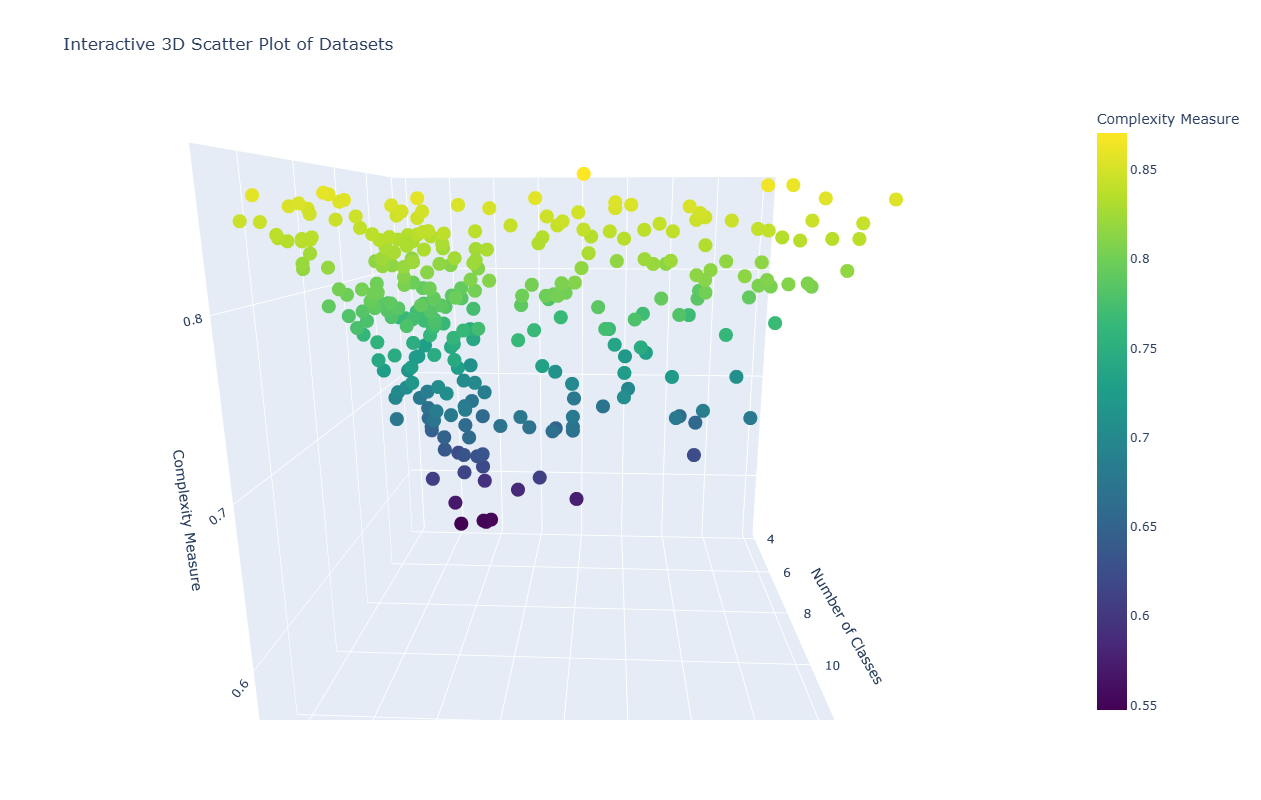

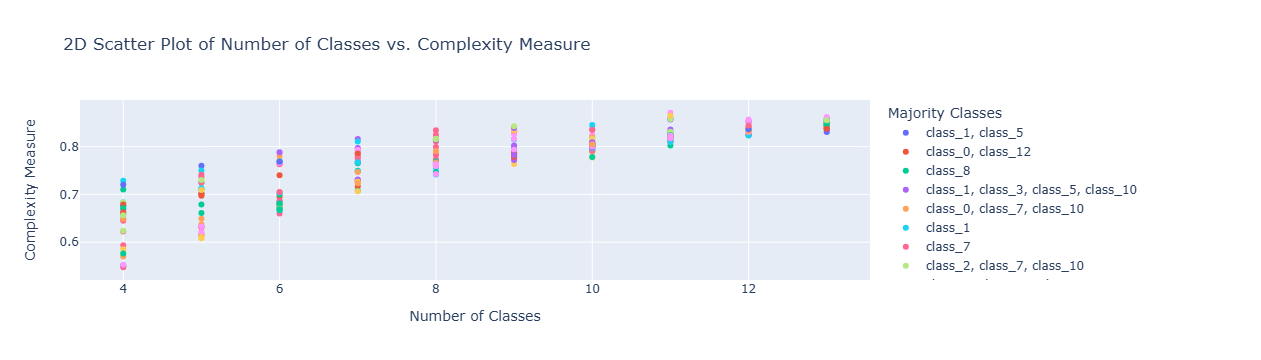

In [5]:
import pandas as pd
import plotly.express as px
import numpy as np

# Load the datasets
summary_df = pd.read_csv('/data/private/BreizhCrops/experiments/undersampled_csvs/dataset_generation/candidate_datasets_42/candidate_datasets_summary.csv')
complexity_df = pd.read_csv('/data/private/BreizhCrops/experiments/undersampled_csvs/dataset_generation/candidate_datasets_42/complexity_results.csv')

# Merge the dataframes on 'dataset_id'
merged_df = pd.merge(summary_df, complexity_df, on='dataset_id')

# Calculate the number of classes in each dataset
merged_df['num_classes'] = merged_df.iloc[:, 1:14].astype(bool).sum(axis=1)

# Define the threshold percentage
threshold_percentage = 1  # 1%

# Function to determine majority classes
def get_majority_classes(row, threshold_percentage):
    max_count = row.max()
    threshold = max_count * (threshold_percentage / 100)
    majority_classes = [idx for idx, val in row.items() if max_count - val <= threshold]
    return majority_classes

# Apply the function to each row to find majority classes
majority_classes_list = merged_df.iloc[:, 1:14].apply(lambda row: get_majority_classes(row, threshold_percentage), axis=1)

# Convert list of majority classes to a string for hover data
merged_df['majority_classes'] = majority_classes_list.apply(lambda x: ', '.join(x))

# Extract class numbers for plotting
merged_df['majority_class_nums'] = majority_classes_list.apply(lambda x: ', '.join([str(int(cls.split('_')[1]) + 1) for cls in x]))

# Create an interactive 3D scatter plot
fig_3d = px.scatter_3d(
    merged_df, 
    x='num_classes', 
    y='majority_class_nums', 
    z='complexity', 
    color='complexity',
    color_continuous_scale='Viridis',
    labels={
        'num_classes': 'Number of Classes',
        'majority_class_nums': 'Majority Class Numbers',
        'complexity': 'Complexity Measure'
    },
    title='Interactive 3D Scatter Plot of Datasets',
    hover_data={'dataset_id': True, 'majority_classes': True}
)

fig_3d.update_layout(
    width=1000,
    height=800,
)

# Create a 2D scatter plot with categorical coloring
fig_2d = px.scatter(
    merged_df, 
    x='num_classes', 
    y='complexity', 
    color='majority_classes',
    labels={
        'num_classes': 'Number of Classes',
        'complexity': 'Complexity Measure',
        'majority_classes': 'Majority Classes'
    },
    title='2D Scatter Plot of Number of Classes vs. Complexity Measure',
    hover_data={'dataset_id': True}
)

# Display both plots
fig_3d.show()
fig_2d.show()


Selected datasets: 194, 290, 244, 136, 59, 75, 257, 106, 267, 269
    